Import Packages

In [1]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import glob
import json
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from utils import score, visualize_result, storeData, readData, create_sequences, setSeed


pollutant = ['O3', 'CO', 'NO2', 'SO2', 'PM2.5', 'PM10']
environment = ['RH', 'AMB_TEMP']


sgx_sensor_dict = {'c1_4#ec_na#0': 'O3',
                   'c1_0#ec_na#0': 'CO',
                   'c1_3#ec_na#0': 'NO2',
                   'c1_5#ec_na#0': 'SO2'}

unit_table = {'O3': 'ppb', 
              'CO': 'ppm',
              'NO2': 'ppb',
              'SO2': 'ppb'}


2023

In [11]:
ref_data = pd.read_csv('data/reference.csv', index_col = [0])
ref_data.index = pd.to_datetime(ref_data.index)
ref_data
# max_id = ref_data.iloc[1737:1954, 1].idxmax()
# ref_data.loc[max_id - timedelta(hours=5):max_id + timedelta(hours=5)]

,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP
2023-01-01 00:00:00,38.7,0.23,4.8,1.0,14.0,14.0,86.0,18.4
2023-01-01 01:00:00,38.3,0.22,5.3,0.4,9.0,13.0,87.0,18.6
2023-01-01 02:00:00,38.3,0.22,4.4,0.2,6.0,8.0,89.0,18.5
2023-01-01 03:00:00,38.3,0.21,4.1,0.1,8.0,3.0,88.0,18.6
2023-01-01 04:00:00,38.2,0.20,3.9,0.5,5.0,4.0,88.0,18.9
...,...,...,...,...,...,...,...,...
2023-05-08 06:00:00,33.0,0.27,10.2,0.7,6.0,7.0,97.0,19.0
2023-05-08 07:00:00,28.5,0.36,14.0,0.6,4.0,6.0,97.0,19.1
2023-05-08 08:00:00,29.2,0.39,14.6,0.7,4.0,6.0,97.0,19.5
2023-05-08 09:00:00,28.6,0.40,16.9,0.8,6.0,4.0,95.0,20.0


SGX

In [12]:
sgx_data = pd.read_csv('data/sgx.csv', index_col = [0])
sgx_data.index = pd.to_datetime(sgx_data.index)
sgx_data

,SGX-O3,SGX-CO,SGX-NO2,SGX-SO2
measure_time,,,,
2023-01-01 08:00:00,-1.539167,6.763333,28.492500,115.645333
2023-01-01 09:00:00,-0.052000,5.354000,35.532833,143.715667
2023-01-01 10:00:00,-0.260333,5.516667,41.556333,168.006500
2023-01-01 11:00:00,-0.130000,5.578000,44.988500,184.928333
2023-01-01 12:00:00,-0.469000,6.089000,45.418000,196.317667
...,...,...,...,...
2023-05-08 03:00:00,-5.111000,5.618333,16.338333,62.893000
2023-05-08 04:00:00,-7.545500,5.571833,15.202000,63.095667
2023-05-08 05:00:00,-5.560500,6.033333,13.828833,62.422000


In [13]:
dates = sgx_data.loc[sgx_data.index.isin(ref_data.index), :].index

# Calculate the difference between the first element and the rest of the elements
diff_from_first = dates - dates[0]

# Convert the differences to hours
diff_in_hours = diff_from_first.total_seconds() / 3600

print(diff_in_hours)

Index([   0.0,    1.0,    2.0,    3.0,    4.0,    5.0,    6.0,    7.0,    8.0,
          9.0,
       ...
       3038.0, 3039.0, 3040.0, 3041.0, 3042.0, 3043.0, 3044.0, 3045.0, 3046.0,
       3047.0],
      dtype='float64', name='measure_time', length=2488)


In [14]:
data = pd.concat([ref_data, sgx_data], axis = 1)
data = data.reindex(data.index, fill_value=np.nan)

data = data[-500:]

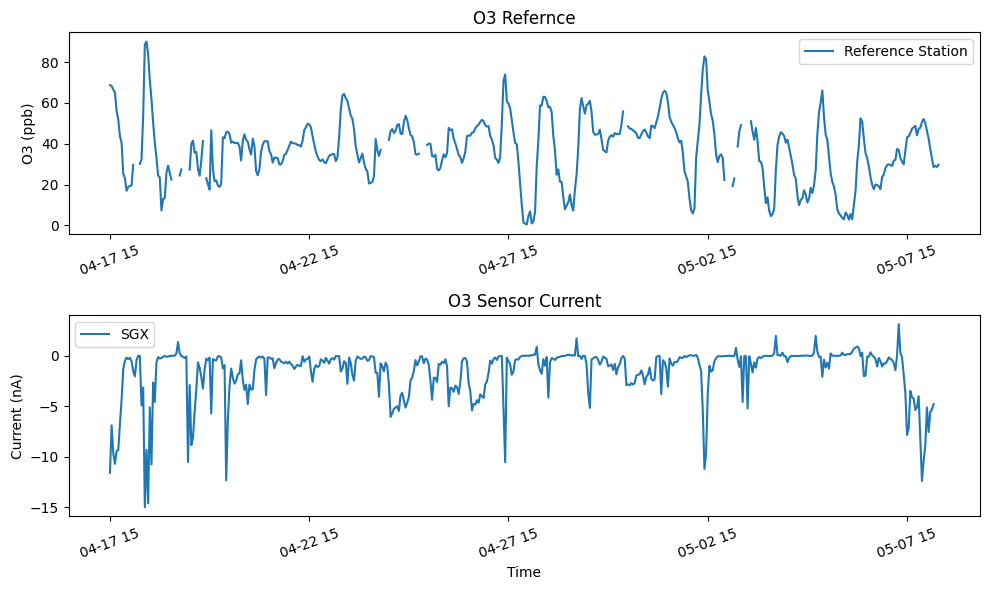

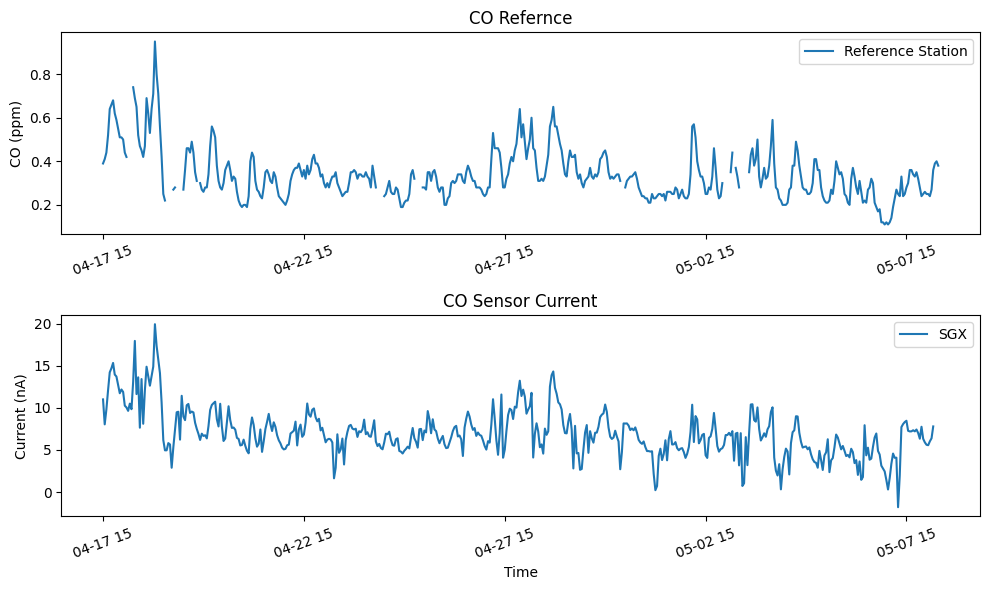

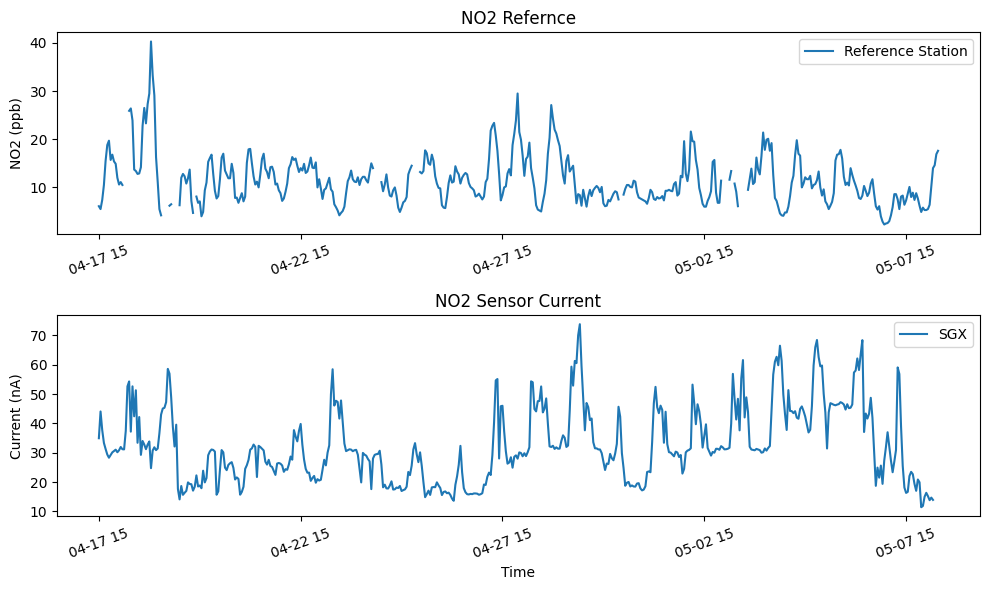

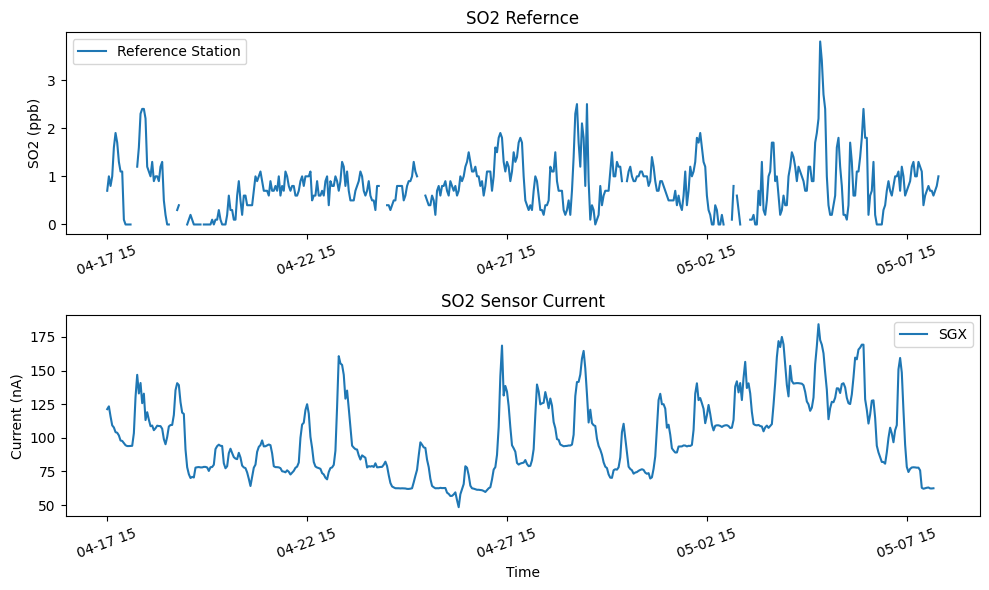

In [15]:
for gas in pollutant[:4]:
    labels = list(map(lambda x: str(x)[5:13], data.index[::120]))
    fig = plt.figure(figsize=(10, 6))

    ax1 = plt.subplot(211)
    ax1.set_title(f'{gas} Refernce')
    ax1.plot(data['REF-' + gas].values, label = 'Reference Station')
    ax1.legend()
    ax1.set_xticks(ticks = list(np.arange(0, len(data.index), 120)))
    ax1.set_xticklabels(labels = labels, rotation = 20)
    ax1.set_ylabel(f'{gas} ({unit_table[gas]})')
    

    ax2 = plt.subplot(212, sharex = ax1)
    ax2.set_title(f'{gas} Sensor Current')
    ax2.plot(data['SGX-' + gas].values, label = 'SGX')
    ax2.legend()
    ax2.set_xticks(ticks = list(np.arange(0, len(data.index), 120)))
    ax2.set_xticklabels(labels = labels, rotation = 20)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Current (nA)')

    plt.tight_layout()
    plt.savefig(f'fig/{gas}_comparison.png', dpi=300, bbox_inches='tight')


Correlation heatmap

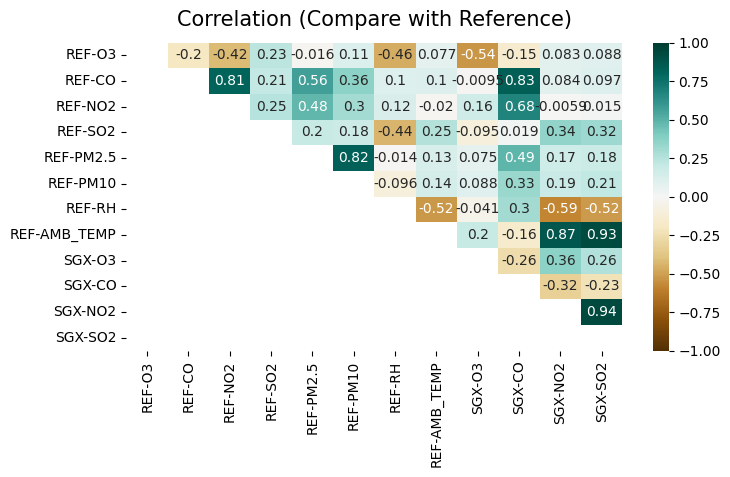

In [16]:
df = data.dropna().iloc[:, :12]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.tril(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', mask=mask)
heatmap.set_title('Correlation (Compare with Reference)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/correlation_heatmap_outer.png', dpi=300, bbox_inches='tight')

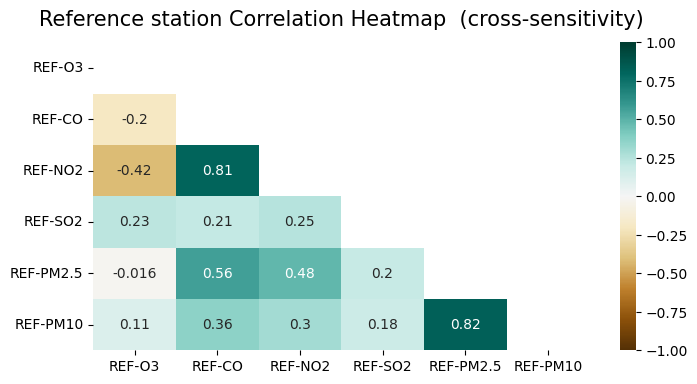

In [9]:
df = data.dropna().iloc[:, 0:6]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Reference station Correlation Heatmap  (cross-sensitivity)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/ref_correlation_heatmap.png', dpi=300, bbox_inches='tight')

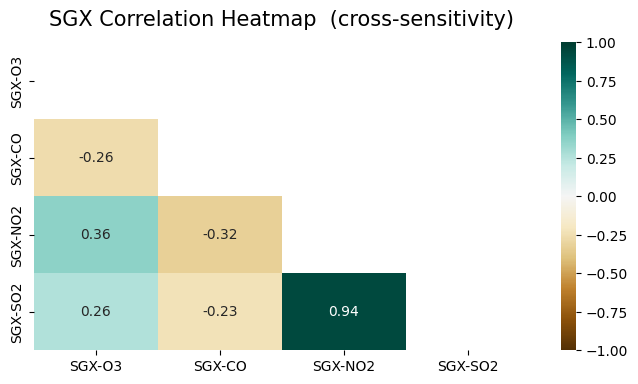

In [17]:
df = data.dropna().iloc[:, 8:12]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('SGX Correlation Heatmap  (cross-sensitivity)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/sgx_correlation_heatmap.png', dpi=300, bbox_inches='tight')

Target Gas & Settings

In [6]:
gas = 'CO'

Sensor Drift #1